In [37]:
pip install pandas numpy scikit-learn matplotlib seaborn openpyxl


Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Dataset Source: https://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx

In [38]:
# Dataset Source: https://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.cluster import KMeans
import sqlite3

In [39]:
# Dataset Source: https://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx
file_path = "C:/Users/My Pc/Downloads/project dataset/project dataset.xlsx"
df = pd.read_excel(file_path, sheet_name='Year 2009-2010')
print("Loaded columns:\n", df.columns)

Loaded columns:
 Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')



--- Data Overview ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB
None
            Quantity                    InvoiceDate          Price  \
count  525461.000000                         525461  525461.000000   
mean       10.337667  2010-06-28 11:37:36.845017856       4.688834   
min     -9600.000000            2009-12-01 07:45:00  -53594.360000   


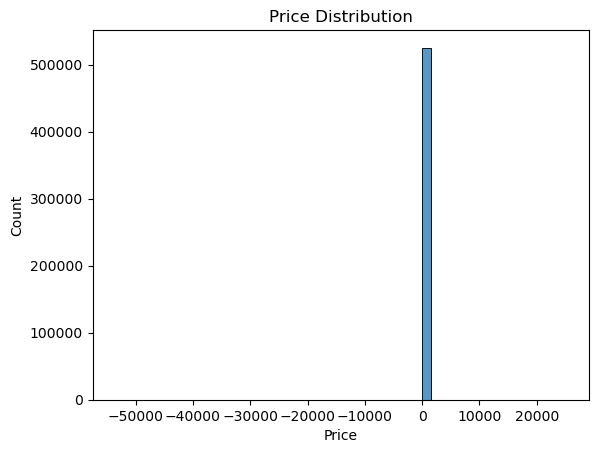


Missing values:
 Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

Duplicate rows: 6865


In [40]:
print("\n--- Data Overview ---")
print(df.info())
print(df.describe())
print("\nTop 5 Countries:\n", df['Country'].value_counts().head())
sns.histplot(df['Price'], bins=50)
plt.title('Price Distribution')
plt.show()

print("\nMissing values:\n", df.isnull().sum())
print("\nDuplicate rows:", df.duplicated().sum())

In [41]:
df = df[df['Customer ID'].notnull()]
df = df[~df['Invoice'].astype(str).str.startswith('C')]
df = df[df['Quantity'] > 0]
df = df[df['Price'] > 0]
df['TotalPrice'] = df['Quantity'] * df['Price']


In [42]:
reference_date = df['InvoiceDate'].max()
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'Invoice': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
print("\nRFM Table Sample:\n", rfm.head())


RFM Table Sample:
    CustomerID  Recency  Frequency  Monetary
0     12346.0      164         11    372.86
1     12347.0        2          2   1323.32
2     12348.0       73          1    222.16
3     12349.0       42          3   2671.14
4     12351.0       10          1    300.93


In [43]:
rfm['AvgOrderValue'] = rfm['Monetary'] / rfm['Frequency']
print("\nWith AvgOrderValue:\n", rfm[['CustomerID', 'AvgOrderValue']].head())


With AvgOrderValue:
    CustomerID  AvgOrderValue
0     12346.0      33.896364
1     12347.0     661.660000
2     12348.0     222.160000
3     12349.0     890.380000
4     12351.0     300.930000


In [44]:
rfm['CLV'] = rfm['AvgOrderValue'] * rfm['Frequency'] / (rfm['Recency'] + 1)
print("\nWith CLV:\n", rfm[['CustomerID', 'CLV']].head())



With CLV:
    CustomerID         CLV
0     12346.0    2.259758
1     12347.0  441.106667
2     12348.0    3.002162
3     12349.0   62.119535
4     12351.0   27.357273


In [45]:
X = rfm[['Recency', 'Frequency', 'Monetary', 'AvgOrderValue']]
y = rfm['CLV']
print("\nFeatures used for modeling:\n", X.head())
print("\nTarget (CLV):\n", y.head())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)



Features used for modeling:
    Recency  Frequency  Monetary  AvgOrderValue
0      164         11    372.86      33.896364
1        2          2   1323.32     661.660000
2       73          1    222.16     222.160000
3       42          3   2671.14     890.380000
4       10          1    300.93     300.930000

Target (CLV):
 0      2.259758
1    441.106667
2      3.002162
3     62.119535
4     27.357273
Name: CLV, dtype: float64


RandomForestRegressor(random_state=42)

In [46]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\nMean Absolute Error (MAE): {mae:.2f}")
print(f"R\u00b2 Score: {r2:.2f}")


Mean Absolute Error (MAE): 62.19
R² Score: 0.87


In [47]:
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
print("Cross-validated MAE:", -np.mean(cv_scores))


Cross-validated MAE: 217.54575588481026



Feature Importances:
Recency: 0.0524
Frequency: 0.3277
Monetary: 0.6067
AvgOrderValue: 0.0132


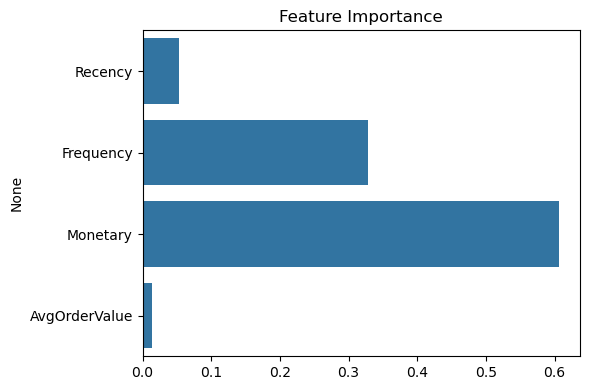

In [48]:
importances = model.feature_importances_
features = X.columns
print("\nFeature Importances:")
for feat, imp in zip(features, importances):
    print(f"{feat}: {imp:.4f}")

plt.figure(figsize=(6, 4))
sns.barplot(x=importances, y=features)
plt.title("Feature Importance")
plt.tight_layout()
plt.show()


In [49]:
top_customers = rfm.sort_values(by='CLV', ascending=False).head(10)
print("\nTop 10 Customers by CLV:\n", top_customers)


Top 10 Customers by CLV:
       CustomerID  Recency  Frequency   Monetary  AvgOrderValue            CLV
4183     18102.0        0         89  349164.35    3923.194944  349164.350000
1840     14911.0        0        205  152147.57     742.183268  152147.570000
2133     15311.0        0        121   56003.26     462.836860   56003.260000
3989     17841.0        0         91   29892.50     328.489011   29892.500000
3744     17511.0        2         31   84541.17    2727.134516   28180.390000
1269     14156.0        6        102  196566.74    1927.124902   28080.962857
1951     15061.0        2         86   83284.38     968.423023   27761.460000
1637     14646.0        9         78  248396.50    3184.570513   24839.650000
1181     14031.0        0         27   23712.31     878.233704   23712.310000
251      12748.0        0        144   22879.66     158.886528   22879.660000



Customer Segments (Cluster Counts):
 Cluster
0    4236
3      68
2       6
1       2
Name: count, dtype: int64


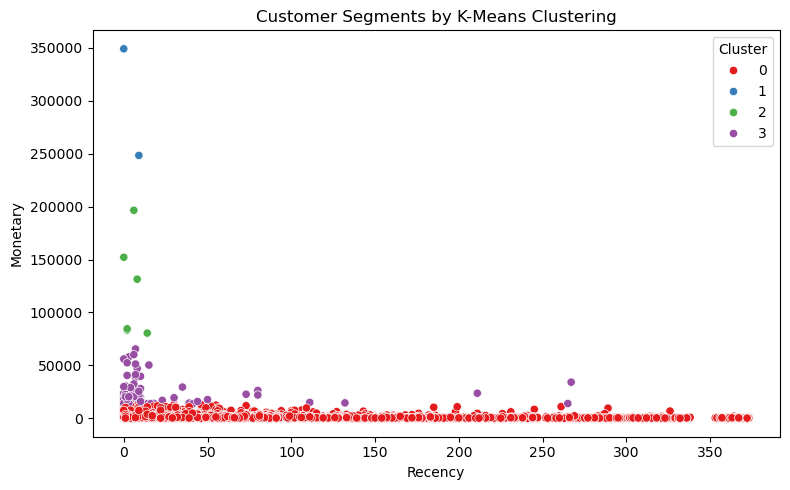

In [50]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm[['Recency', 'Frequency', 'Monetary']])
print("\nCustomer Segments (Cluster Counts):\n", rfm['Cluster'].value_counts())

plt.figure(figsize=(8, 5))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='Set1')
plt.title("Customer Segments by K-Means Clustering")
plt.xlabel("Recency")
plt.ylabel("Monetary")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

In [51]:
print("\n--- SQL-style Summary ---")
conn = sqlite3.connect(':memory:')
df.to_sql('sales', conn, index=False)
query = """
SELECT Country, COUNT(DISTINCT [Customer ID]) as Total_Customers,
       SUM(TotalPrice) as Revenue
FROM sales
GROUP BY Country
ORDER BY Revenue DESC
LIMIT 5
"""
summary = pd.read_sql(query, conn)
print(summary)
conn.close()



--- SQL-style Summary ---
          Country  Total_Customers      Revenue
0  United Kingdom             3969  7414755.963
1            EIRE                5   356085.210
2     Netherlands               22   268786.000
3         Germany               67   202395.321
4          France               47   146215.420
